## imports

In [1]:
import  common.common_machine_learning as common
import pandas as pd
import numpy as np
import time
import string
from nltk.corpus import stopwords 
import re
import matplotlib.pyplot as plt 
import seaborn as sns

Ignore FutureWarning's

In [2]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

## Bibliografia 

Los features basados en strings que se extraen del set datos, estan basados en la siguiente publicacion de kaggle para otro set de datos.

Biblografia:
https://www.kaggle.com/lalitparihar44/detailed-text-based-feature-engineering

Funciones de la publicacion que re-utilizo

In [3]:
#Function for removing punctuations from string
def remove_punctuations_from_string(string1):
    string1 = string1.lower() #changing to lower case
    translation_table = dict.fromkeys(map(ord, string.punctuation), ' ') #creating dictionary of punc & None
    string2 = string1.translate(translation_table) #translating string1
    return string2
#lets check the function on our test string.

In [4]:
#The punctuations have been removed from the string. Lets write a similar function for removing
#stopwords.
def remove_stopwords_from_string(string1):
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('spanish')) + r')\b\s*') #compiling all stopwords.
    string2 = pattern.sub('', string1) #replacing the occurrences of stopwords in string1
    return string2

## Constantes

In [28]:
_SOLO_PALABRAS_IMPORTANTES = '_solo_palabras_importantes'
_SIN_SIGNOS_PUNTUACION = '_sin_signos_puntuacion'
_CANTIDAD_PALABRAS_IMPORTANTES = '_cantidad_palabras_importantes'
_CANTIDAD_CARACTERES_IMPORTANTES = '_cantidad_caracteres_en_palabras_importantes'
_LONGITUD_MEDIA_PALABRA  = '_longitud_media_de_palabra'
_CANTIDAD_STOPWORDS = '_cantidad_stopwords'
_CANTIDAD_SIGNOS_PUNTACION = '_cantidad_signos_puntacion'
_CANTIDAD_PALABRAS_MAYUSCULA = '_cantidad_palabras_en_mayuscula'
_CANTIDAD_TITULOS = '_cantidad_titulos'

_CANTIDAD_PALABRAS_TOP_K = '_cantidad_palabras_top_k'
_CANTIDAD_PALABRAS_BOTTOM_K = '_cantidad_palabras_bottom_k'
_CANTIDAD_PALABRAS_EMPIEZAN_TOP_K  = '_cantidad_palabras_empiezan_en_top_k'
_CANTIDAD_PALARAS_TERMINAN_TOP_K = 'cantidad_palabras_terminan_en_top_k'

FIG_WIDTH = 15
FIG_HEIGHT = 5


## Funciones auxiliares

In [6]:
def plot_precio_vs_feature(lista_cols, sufijo_feature, lista_cotas = []):    
    colores = ['blue', 'orange', 'green']
    for i, col in enumerate(lista_cols):
        train_plot = train_strings
        if lista_cotas != []:
            train_plot = train_plot.loc[train_plot[col + sufijo_feature] < lista_cotas[i]] 
        plt.figure()
        plt.scatter(train_plot[col + sufijo_feature], train_plot['precio'], color = colores[i%3])
        plt.xlabel(sufijo_feature.replace('_',' '))
        plt.ylabel('Precio')
        plt.title('Precio VS \n' + sufijo_feature.replace('_',' ') + '\npor ' + col)

In [78]:
def plot_feature_precio_cantidad(lista_cols, sufijo_feature, cotas_feature = [], cotas_cantidad_registros = [], cotas_precio = [], indice_color_inicial = 0):
    colores = ['blue', 'orange', 'green']
    train_plot = train_strings.copy()
    train_plot['cuenta'] = 1
    for i, col in enumerate(lista_cols):        
        if cotas_feature != []:
            serie_feature = train_plot[col + sufijo_feature]
            cota_inferior = cotas_feature[i][0]
            cota_superior = cotas_feature[i][1]
            if cota_inferior != None:
                train_plot = train_plot.loc[cota_inferior < serie_feature]
            if cota_superior != None:
                train_plot = train_plot.loc[serie_feature < cota_superior]
                                            
        if cotas_cantidad_registros != [] :
            grupo_serie_cuenta = train_plot.groupby([col + sufijo_feature])['cuenta']
            cota_inferior = cotas_cantidad_registros[i][0]                            
            cota_superior = cotas_cantidad_registros[i][1]
            if cota_inferior != None:
                train_plot = train_plot.loc[grupo_serie_cuenta.transform(lambda x : cota_inferior < x.sum())]
            if cota_superior != None:
                train_plot = train_plot.loc[grupo_serie_cuenta.transform(lambda x : x.sum() < cota_superior)]
        
        if cotas_precio != []:
            serie_precio = train_plot['precio']
            cota_inferior = cotas_precio[i][0]
            cota_superior = cotas_precio[i][1]
            if cota_inferior != None: 
                train_plot = train_plot.loc[cota_inferior < serie_precio]
            if cota_superior != None:
                train_plot = train_plot.loc[serie_precio < cota_superior]
        
        fig, ax =  plt.subplots(1,2, figsize = (FIG_WIDTH,FIG_HEIGHT))
        
        ax[0].scatter(train_plot[col + sufijo_feature], train_plot['precio'], color = colores[i+indice_color_inicial%len(colores)], s = 1)
        ax[0].set_title('Scatterplot :\nPrecio vs \n' + sufijo_feature.replace('_', ' ') + '\npor ' + col)
        ax[0].set_xlabel(sufijo_feature.replace('_',' '))
        ax[0].set_ylabel('Precio [pesos mexicanos]')
        train_cuenta = train_plot[col + sufijo_feature].value_counts()
        DEBUG = train_cuenta
        ax[1].bar(train_cuenta.index, train_cuenta.values, color = colores[i+indice_color_inicial%len(colores)])
        ax[1].set_title('Countplot :\nCantidad registros vs \n' + sufijo_feature.replace('_', ' ') + '\npor ' + col)
        ax[1].set_xlabel(sufijo_feature.replace('_',' '))
        ax[1].set_ylabel('Cantidad de registros \nen el set de train')
        

## Set de datos

In [8]:
train = common.cargar_set_optimizado('sets_de_datos/train.csv', index_col = 0)

## Analisis

In [9]:
cols_string = ['titulo', 'descripcion', 'direccion']
train_strings = train[cols_string+['precio']]
display(train_strings)

,titulo,descripcion,direccion,precio
id,,,,
254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Avenida Division del Norte 2005,2273000.0
53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",AV. MEXICO,3600000.0
247984,casa en venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,Urbi Tonala,1200000.0
209067,casa sola en toluca zinacantepec con credito i...,casa en privada con caseta de vigilancia casas...,IGNACIO MANUEL ALTAMIRANO 128,650000.0
185997,paseos del sol,bonito departamento en excelentes condiciones ...,PASEOS DEL SOL,1150000.0
126147,departamento en venta taxqueña,"amplio departamento, estancia de sala y comedo...",Condominio Tlalpan 2B,1100000.0
139233,de oportunidad casa en san lorenzo,"ubicada en esquina, pertenece san lorenzo agen...",NaN,1150000.0
5013,casa emilia en venta en selvamar playa del carmen,casa emilia en venta playa del carmenfracciona...,condominio el trebol,4200000.0
44962,pre- venta preciosos depas 2 recamaras con sub...,<p>pre-venta de preciosos departamento ecologi...,BUENAVISTA DEPTOS CON SUBSIDIO,310000.0


In [10]:
train_strings.isnull().sum()

titulo          5387
descripcion     1619
direccion      53072
precio             0
dtype: int64

In [11]:
train_strings = train_strings.fillna(value = {'titulo' : '', 'descripcion' : '', 'direccion' : ''})
train_strings.isnull().sum()

titulo         0
descripcion    0
direccion      0
precio         0
dtype: int64

La siguiente operacion toma unos minutos

In [12]:
t0 = time.time()
for col in cols_string:
    train_strings[col + _SIN_SIGNOS_PUNTUACION] = train_strings[col].apply(
                                                        lambda x: remove_punctuations_from_string(x))
    train_strings[col + _SOLO_PALABRAS_IMPORTANTES] =\
        train_strings[col + _SIN_SIGNOS_PUNTUACION].apply(lambda x: 
                                                                remove_stopwords_from_string(x))
t1 = time.time()
print('Tiempo: {:.0f} segundos'.format(t1-t0))

Tiempo: 119 segundos


In [13]:
train_strings

,titulo,descripcion,direccion,precio,titulo_sin_signos_puntuacion,titulo_solo_palabras_importantes,descripcion_sin_signos_puntuacion,descripcion_solo_palabras_importantes,direccion_sin_signos_puntuacion,direccion_solo_palabras_importantes
id,,,,,,,,,,
254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Avenida Division del Norte 2005,2273000.0,depto tipo a 402,depto tipo 402,depto interior de 80 15m2 consta de sala com...,depto interior 80 15m2 consta sala comedor c...,avenida division del norte 2005,avenida division norte 2005
53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",AV. MEXICO,3600000.0,condominio horizontal en venta,condominio horizontal venta,p entre sonora y guerrero atr aacute s del h...,p sonora guerrero atr aacute s hospital aac...,av mexico,av mexico
247984,casa en venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,Urbi Tonala,1200000.0,casa en venta urbi 3 recamaras tonala,casa venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,descripcion \nmejor ubicacion residencial orie...,urbi tonala,urbi tonala
209067,casa sola en toluca zinacantepec con credito i...,casa en privada con caseta de vigilancia casas...,IGNACIO MANUEL ALTAMIRANO 128,650000.0,casa sola en toluca zinacantepec con credito i...,casa sola toluca zinacantepec credito infonavi...,casa en privada con caseta de vigilancia casas...,casa privada caseta vigilancia casas dos tres ...,ignacio manuel altamirano 128,ignacio manuel altamirano 128
185997,paseos del sol,bonito departamento en excelentes condiciones ...,PASEOS DEL SOL,1150000.0,paseos del sol,paseos sol,bonito departamento en excelentes condiciones ...,bonito departamento excelentes condiciones bue...,paseos del sol,paseos sol
126147,departamento en venta taxqueña,"amplio departamento, estancia de sala y comedo...",Condominio Tlalpan 2B,1100000.0,departamento en venta taxqueña,departamento venta taxqueña,amplio departamento estancia de sala y comedo...,amplio departamento estancia sala comedor par...,condominio tlalpan 2b,condominio tlalpan 2b
139233,de oportunidad casa en san lorenzo,"ubicada en esquina, pertenece san lorenzo agen...",,1150000.0,de oportunidad casa en san lorenzo,oportunidad casa san lorenzo,ubicada en esquina pertenece san lorenzo agen...,ubicada esquina pertenece san lorenzo agencia...,,
5013,casa emilia en venta en selvamar playa del carmen,casa emilia en venta playa del carmenfracciona...,condominio el trebol,4200000.0,casa emilia en venta en selvamar playa del carmen,casa emilia venta selvamar playa carmen,casa emilia en venta playa del carmenfracciona...,casa emilia venta playa carmenfraccionamiento ...,condominio el trebol,condominio trebol
44962,pre- venta preciosos depas 2 recamaras con sub...,<p>pre-venta de preciosos departamento ecologi...,BUENAVISTA DEPTOS CON SUBSIDIO,310000.0,pre venta preciosos depas 2 recamaras con sub...,pre venta preciosos depas 2 recamaras subsidio,p pre venta de preciosos departamento ecologi...,p pre venta preciosos departamento ecologicos...,buenavista deptos con subsidio,buenavista deptos subsidio


Features que deseamos generar para Titulo, Descripcion y Direccion:
* F1: Cantidad de palabras importantes 
* F2: Cantidad de caracteres
* F3: Longitud media por palabra
* F4: Cantidad de 'Stopwords'
* F5: Cantidad de signos de puntacion
* F6: Cantidad de palabras en mayuscula
* F7: Cantidad de palabras cuya primer letra es mayuscula y el resto es minuscula: 'Titulos'
* F8: Cantidad de palabras en el top K de palabras (mas frecuentes)
* F9: Cantidad de palabras en el bottom K de palabras (menos frecuentes)
* F10: Cantidad de palabras que empiezan con los prefijos mas frecuentes
* F11: Cantidad de palabras que terminan con los postfijos mas frecuentes 

## F1 : Cantidad de palabras importantes

In [14]:
t0 = time.time()
for col in cols_string:
    train_strings[col + _CANTIDAD_PALABRAS_IMPORTANTES] = train_strings[col + _SOLO_PALABRAS_IMPORTANTES].apply(lambda x: len(str(x).split()))
t1 = time.time()
print('tiempo = {0:.0f} segundos'.format((t1 - t0)))

tiempo = 1 segundos


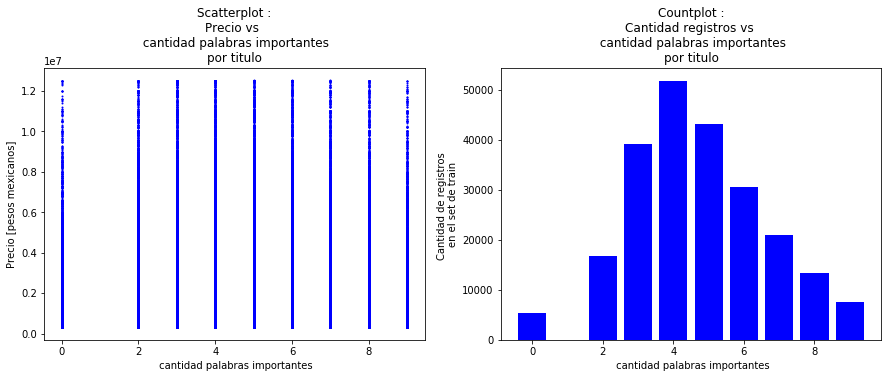

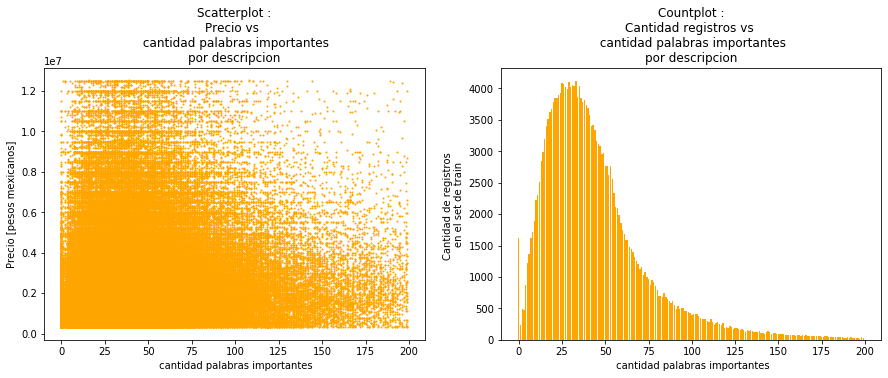

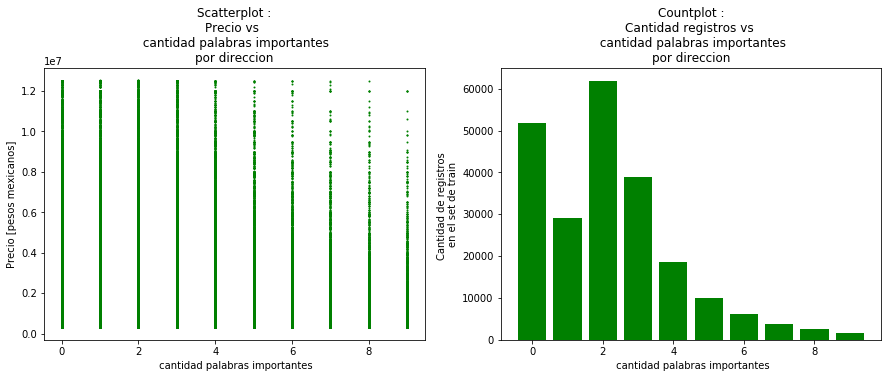

In [43]:
plot_feature_precio_cantidad(
    cols_string, 
    _CANTIDAD_PALABRAS_IMPORTANTES, 
    [(None, None), (None, 200), (None, 10)], 
    [(5000,None), (None, None), (None, None)]
)

Se aprecio que la cantidad de palabras principales por titulo, descripcion o direccion, no afecta a la mayoria de la propiedades de forma significativa 

## F2: Cantidad de caracteres

In [19]:
t0 = time.time()
for col in cols_string:
    train_strings[col + _CANTIDAD_CARACTERES_IMPORTANTES] = train_strings[col + _SOLO_PALABRAS_IMPORTANTES].apply(lambda x: len(str(x)))
t1 = time.time()
print('tiempo = {0:.0f} segundos'.format((t1 - t0)))

tiempo = 0 segundos


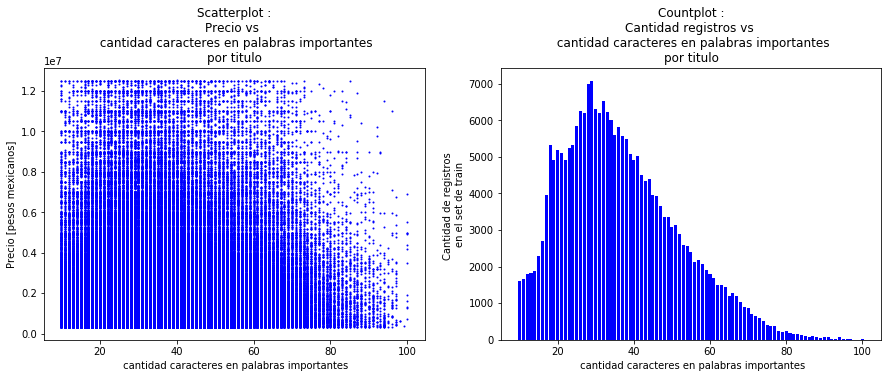

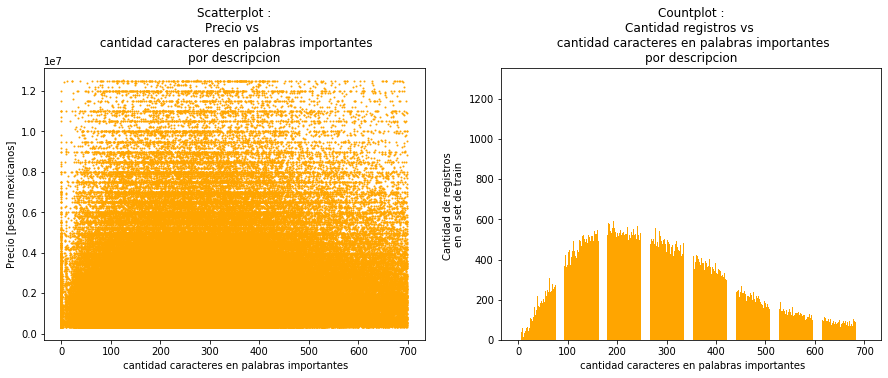

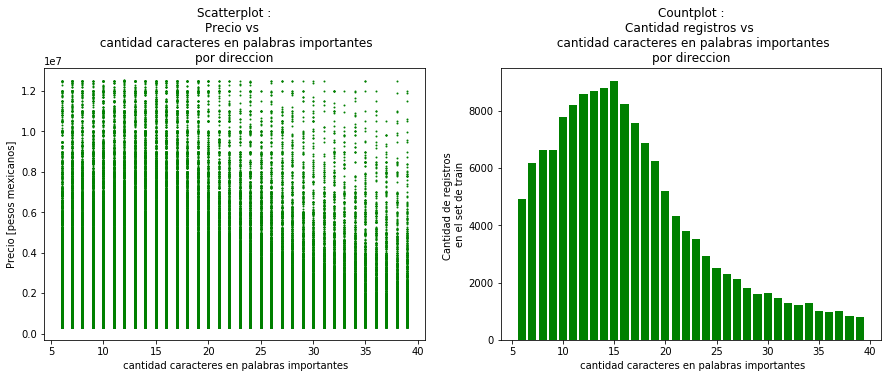

In [42]:
plot_feature_precio_cantidad(
    cols_string, 
    _CANTIDAD_CARACTERES_IMPORTANTES, 
    [(9, None), (None, 700), (5,40)],
    [(None, None),(None, None),(None, None)]
)

En este caso, vemos que tanto titulo, descripcion, y direccion se ven afeactiados es cierto porcentaje pequeño por la cantidad de caracteres usada. 

## F3: Longitud media de palabras [cantidad caracteres] (Aprox.)

In [29]:
t0 = time.time()
for col in cols_string:
    train_strings[col + _LONGITUD_MEDIA_PALABRA] =\
        train_strings[col + _CANTIDAD_CARACTERES_IMPORTANTES] /  train_strings[col + _CANTIDAD_PALABRAS_IMPORTANTES].transform(lambda x: x if x > 0  else 1) 
t1 = time.time()
print('tiempo = {0:.0f} segundos'.format((t1 - t0)))

tiempo = 0 segundos


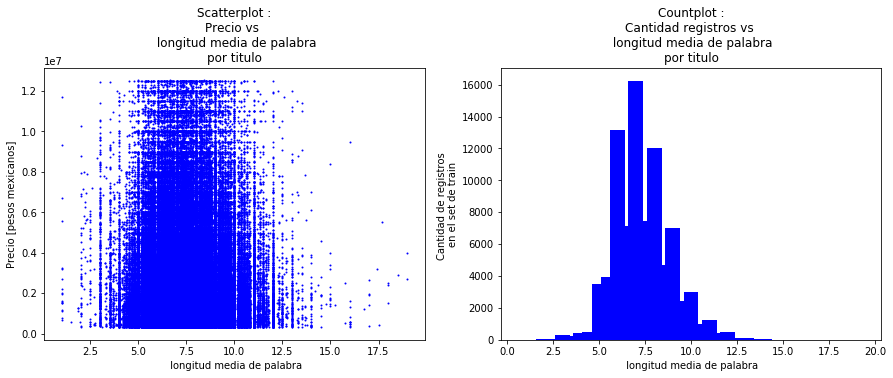

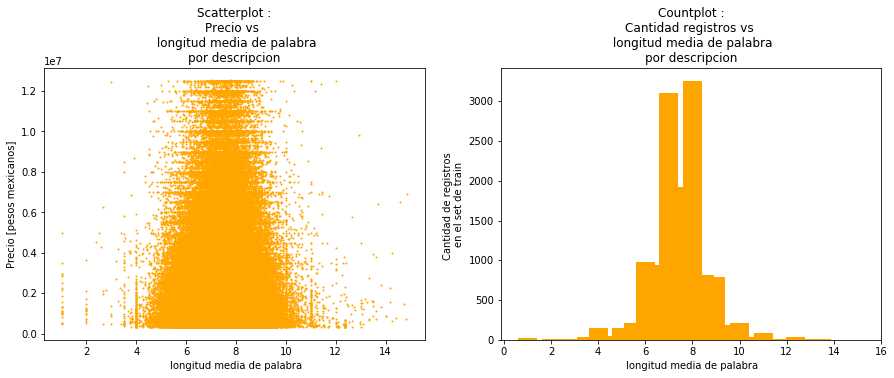

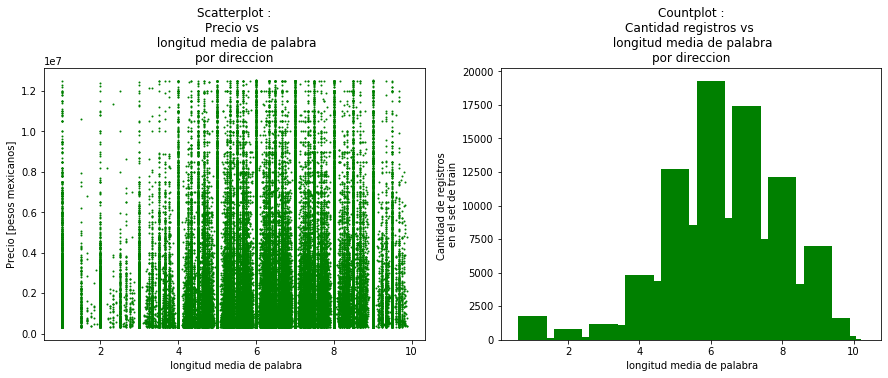

In [41]:
plot_feature_precio_cantidad(
    cols_string, 
    _LONGITUD_MEDIA_PALABRA,
    [(0,20),(0,15),(0,10)],
    [(None,None),(None,None),(None,None)]
)

## F4: Cantidad de 'Stopwords'

In [31]:
t0 = time.time()
stop_words = set(stopwords.words('spanish'))
for col in cols_string:
    train_strings[col + _CANTIDAD_STOPWORDS] =\
        train_strings[col + _SIN_SIGNOS_PUNTUACION].apply(lambda x: len([palabra for palabra in str(x).split() if palabra in stop_words]))
t1 = time.time()
print('tiempo = {0:.0f} segundos'.format((t1 - t0)))

tiempo = 3 segundos


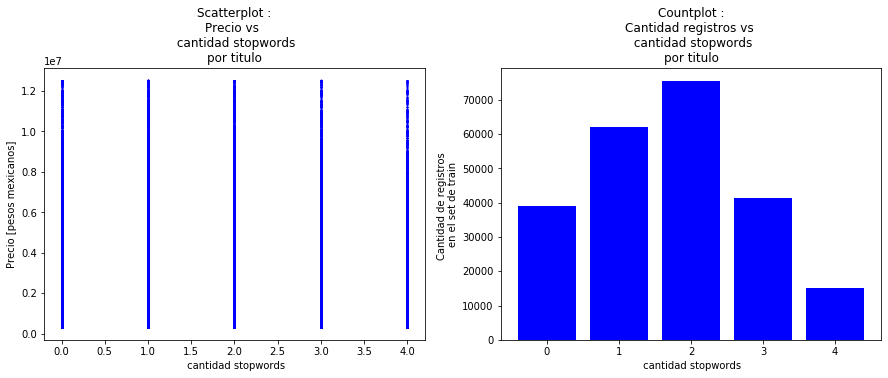

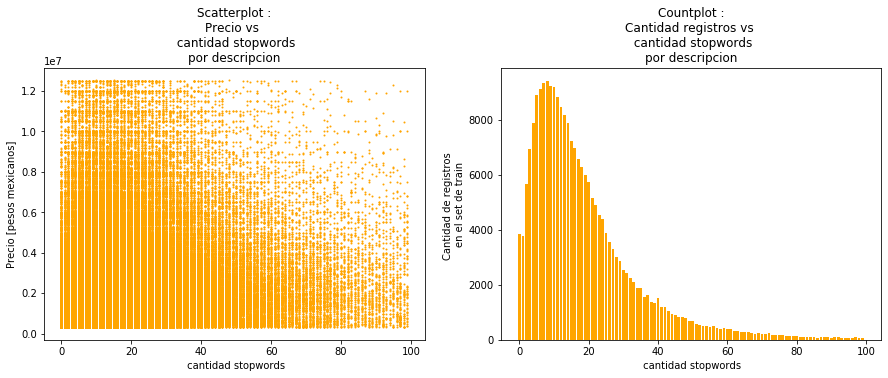

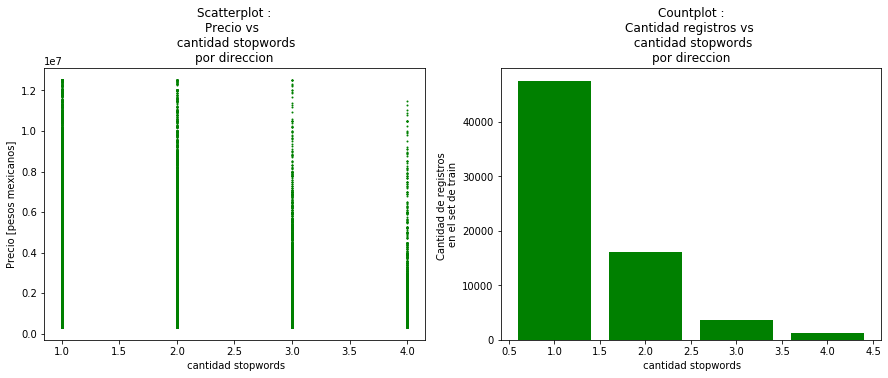

In [40]:
plot_feature_precio_cantidad(
    cols_string, 
    _CANTIDAD_STOPWORDS,
    [(None,None),(None,100),(0,5)],
    [(10000,None),(None,None),(None,None)]
)

## F5: Cantidad de signos de puntacion 

In [35]:
t0 = time.time()
for col in cols_string:
    train_strings[col + _CANTIDAD_SIGNOS_PUNTACION] =\
        train_strings[col].apply(lambda x: len([caracter for caracter in str(x) if caracter in string.punctuation]))
t1 = time.time()
print('tiempo = {0:.0f} segundos'.format((t1 - t0)))

tiempo = 6 segundos


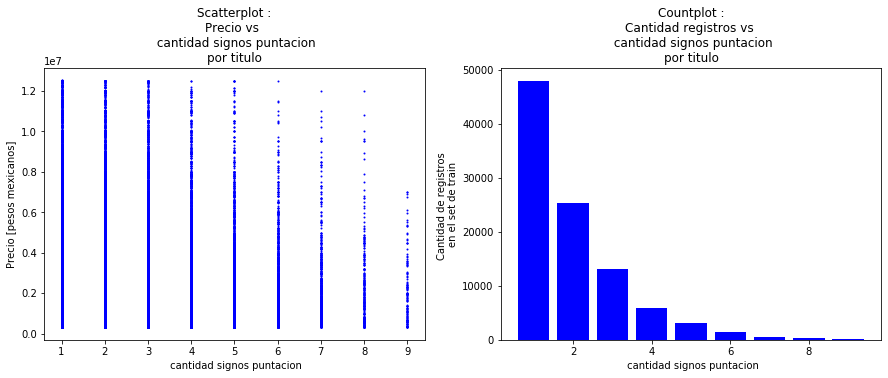

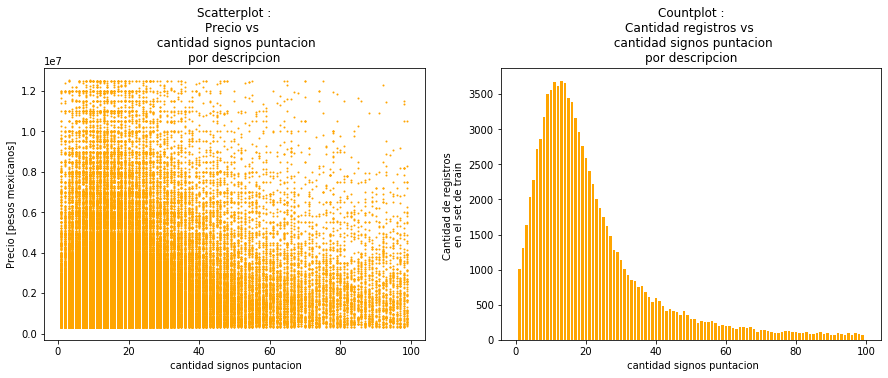

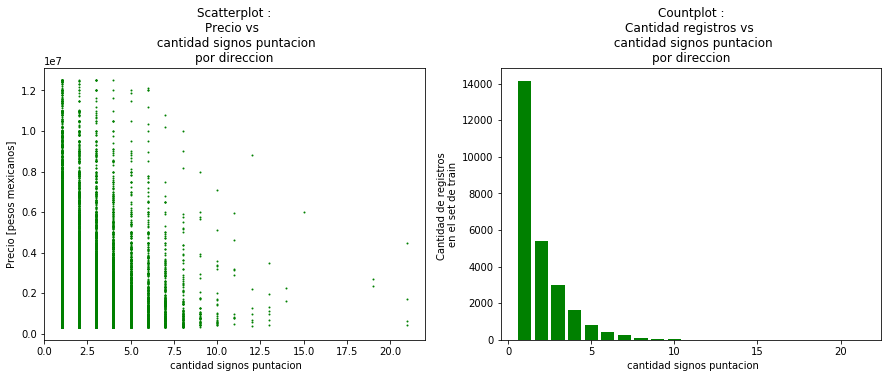

In [39]:
plot_feature_precio_cantidad(
    cols_string, 
    _CANTIDAD_SIGNOS_PUNTACION,
    [(0,10),(0,100),(0,25)],
    [(None,None),(None,None),(None,None)]
)

## F6: Cantidad de palabras en mayuscula

In [44]:
t0 = time.time()
for col in cols_string:
    train_strings[col + _CANTIDAD_PALABRAS_MAYUSCULA] =\
        train_strings[col].apply(lambda x: len([palabra for palabra in str(x).split() if palabra.isupper()]))
t1 = time.time()
print('tiempo = {0:.0f} segundos'.format((t1 - t0)))

tiempo = 2 segundos


In [58]:
train_strings['titulo' + _CANTIDAD_PALABRAS_MAYUSCULA].value_counts()

0    240000
Name: titulo_cantidad_palabras_en_mayuscula, dtype: int64

In [59]:
train_strings['descripcion' + _CANTIDAD_PALABRAS_MAYUSCULA].value_counts()

0    240000
Name: descripcion_cantidad_palabras_en_mayuscula, dtype: int64

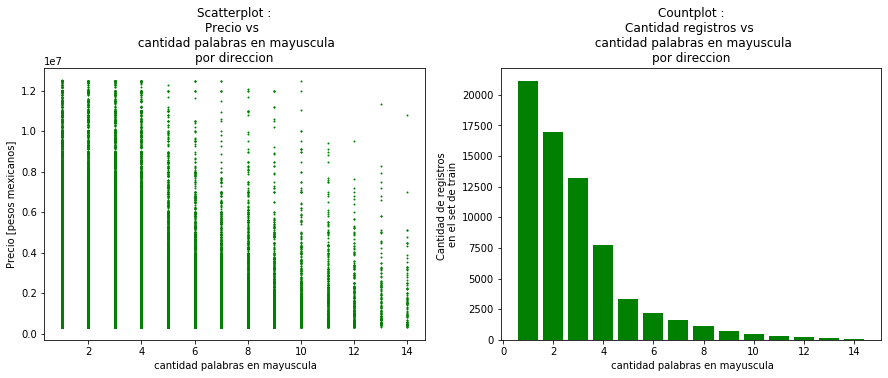

In [84]:
plot_feature_precio_cantidad(
    ['direccion'], 
    _CANTIDAD_PALABRAS_MAYUSCULA,
    [(0,15)],
    [],
    [],
    indice_color_inicial = 2
)

Filtrando los cantidades de palabras en mayuscula cero, las cuales ocupaban mas de la mitad de los registros, encontramos un relacion minoritario entre el precio que baja con la cantidad de direcciones en mayuscula

## F7: Cantidad de palabras cuya primer letra es mayuscula y el resto es minuscula: 'Titulos'

In [52]:
t0 = time.time()
for col in cols_string:
    train_strings[col + _CANTIDAD_TITULOS] =\
        train_strings[col].apply(lambda x: len([palabra for palabra in str(x).split() if palabra.istitle()]))
t1 = time.time()
print('tiempo = {0:.0f} segundos'.format((t1 - t0)))

tiempo = 2 segundos


In [54]:
train_strings['titulo' + _CANTIDAD_TITULOS].value_counts()

0    240000
Name: titulo_cantidad_titulos, dtype: int64

In [55]:
train_strings['descripcion' + _CANTIDAD_TITULOS].value_counts()

0    240000
Name: descripcion_cantidad_titulos, dtype: int64

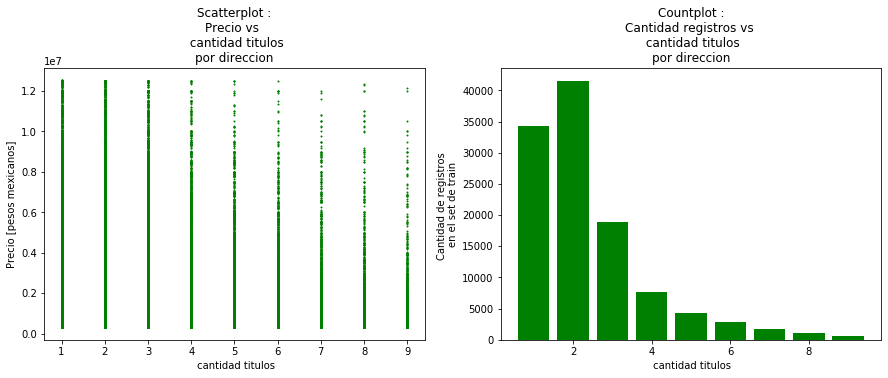

In [83]:
plot_feature_precio_cantidad(
    ['direccion'], 
    _CANTIDAD_TITULOS,
    [(0, 10)],
    [],
    [],
    indice_color_inicial = 2
)

Filtrando la mayor parte del dataset para valores igual a cero en cantidad de titulos, cuya varianza era enorme en relacion al precio, nos quedamos con este grupo minoritario de registros.  
Parece haber una caida del valor de la propiedad con la cantidad de titulos en la direccion.